# Installation

In [2]:
print('1', end='')
# !git clone --quiet 'https://github.com/facebookresearch/detectron2'
print('2', end='')
!pip install 'git+https://github.com/facebookresearch/detectron2.git' -q
print('3', end='')
!pip install 'git+https://github.com/facebookresearch/detectron2@main#subdirectory=projects/DensePose' -q
print('4', end='')
!pip install av -q
!pip install sagemaker-inference -q
print('5', end='')
# !wget -q -O densepose_rcnn_R_50_FPN_s1x_legacy.pkl https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x_legacy/164832157/model_final_d366fa.pkl
# !wget -q -O densepose_rcnn_R_50_FPN_s1x.pkl https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl

12345

In [3]:
!pip list |grep det

detectron2                    0.6
detectron2-densepose          0.6


# Test Inference Code

/home/ec2-user/SageMaker/my_model/code
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
[02/26 10:04:07 muscle_part]: Loading config from ../densepose_rcnn_R_50_FPN_s1x_legacy.yaml
[02/26 10:04:07 muscle_part]: Loading model from ../densepose_rcnn_R_50_FPN_s1x_legacy.pkl
[02/26 10:04:08 muscle_part]: Loading data from 1583.jpeg
[02/26 10:04:08 muscle_part]: Loading config from ../densepose_rcnn_R_50_FPN_s1x_legacy.yaml


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1686274778240/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/26 10:04:10 muscle_part]: Processing muscle_part.png
[02/26 10:04:10 muscle_part]: Output saved to muscle_part.0001.png
exec time: 2.43sec


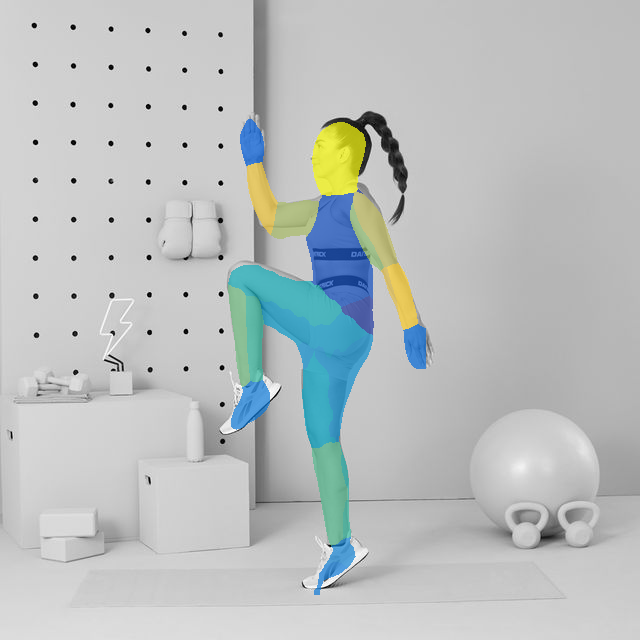

In [1]:
%cd my_model/code
from detectron2.data.detection_utils import read_image
from inference import model_fn, input_fn, predict_fn
from IPython.display import Image

img = read_image('../../1583.jpeg', format="BGR")  # predictor expects BGR image.
model = model_fn('densepose_rcnn_R_50_FPN_s1x_legacy.pkl')
input = input_fn(img, "application/x-image")
output = predict_fn(input, model)
Image(f'muscle_part.0001.png')
%cd ../../

# Deploy Tests

## PyTorchModel by gzip

In [12]:
%%capture
#tar the model
import os
from subprocess import call, DEVNULL
call(["tar", "czf","my_model.tar.gz" , 'my_model'])#, stderr=DEVNULL, stdout=DEVNULL)#stdout=open(os.devnull, 'wb'))

In [3]:
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel

role = get_execution_role()

model = PyTorchModel(
    model_data='my_model.tar.gz',#'s3://human-part-seg/my_model1.tar.gz',
    role=role,
    entry_point='inference.py',
    source_dir="my_model/code",
    py_version="py310",
    framework_version='2.0.1', #pytorch version
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.g4dn.xlarge',
    # serializer=JSONSerializer(),
    # deserializer=JSONDeserializer(),
)

--------------------!

## PyTorchModel by Docker

In [ ]:
%%sh
cd Docker
# The name of our algorithm
algorithm_name=pytorch-densepose-muscle-part-inf

# cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
echo 0
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1
echo 1
if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi
echo 2
# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)
echo 3
# Get the login command from ECR in order to pull down the SageMaker PyTorch image
$(aws ecr get-login --registry-ids 763104351884 --region ${region} --no-include-email)
echo 4
# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} . --build-arg REGION=${region}
echo 5
docker tag ${algorithm_name} ${fullname}
echo 6
docker push ${fullname}
echo 7

In [12]:
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel

role = get_execution_role()

model = PyTorchModel(
    model_data='s3://human-part-seg/my_model1.tar.gz',
    image_uri='478946426939.dkr.ecr.us-east-1.amazonaws.com/pytorch-densepose-muscle-part-inf:latest',
    role=role,
    entry_point='inference.py',
    source_dir="my_model/code",
    py_version="py3",
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [10]:
# deploy is an existing method in the model object, however we have enabled live loggging for easier debugging.
instance_type='ml.g4dn.xlarge'
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type
)

----------!

## PyTorchModel by ModelBuilder

In [4]:
import argparse
import glob
import logging
import os
import sys
from typing import Any, ClassVar, Dict, List
import torch

from detectron2.config import CfgNode, get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.engine.defaults import DefaultPredictor
from detectron2.structures.instances import Instances
from detectron2.utils.logger import setup_logger

from densepose import add_densepose_config
from densepose.structures import DensePoseChartPredictorOutput, DensePoseEmbeddingPredictorOutput
from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose_outputs_vertex import (
    DensePoseOutputsTextureVisualizer,
    DensePoseOutputsVertexVisualizer,
    get_texture_atlases,
)
from densepose.vis.densepose_results import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.densepose_results_textures import (
    DensePoseResultsVisualizerWithTexture,
    get_texture_atlas,
)
from densepose.vis.extractor import (
    CompoundExtractor,
    DensePoseOutputsExtractor,
    DensePoseResultExtractor,
    create_extractor,
)

from time import time


LOGGER_NAME = "muscle_part"
logger = logging.getLogger(LOGGER_NAME)

_ACTION_REGISTRY: Dict[str, "Action"] = {}


class Action:
    @classmethod
    def add_arguments(cls: type, parser: argparse.ArgumentParser):
        parser.add_argument(
            "-v",
            "--verbosity",
            action="count",
            help="Verbose mode. Multiple -v options increase the verbosity.",
        )


def register_action(cls: type):
    """
    Decorator for action classes to automate action registration
    """
    global _ACTION_REGISTRY
    _ACTION_REGISTRY[cls.COMMAND] = cls
    return cls

class InferenceAction(Action):
    @classmethod
    def add_arguments(cls: type, parser: argparse.ArgumentParser):
        super(InferenceAction, cls).add_arguments(parser)
        parser.add_argument("cfg", metavar="<config>", help="Config file")
        parser.add_argument("model", metavar="<model>", help="Model file")
        parser.add_argument("input", metavar="<input>", help="Input data")
        parser.add_argument(
            "--opts",
            help="Modify config options using the command-line 'KEY VALUE' pairs",
            default=[],
            nargs=argparse.REMAINDER,
        )

    @classmethod
    def execute(cls: type, args: argparse.Namespace):
        t0 = time()
        logger.info(f"Loading config from {args.cfg}")
        opts = []
        cfg = cls.setup_config(args.cfg, args.model, args, opts)
        cfg.defrost() # for mac m1 https://github.com/youngwanLEE/vovnet-detectron2/issues/4#issuecomment-592006710
        cfg.MODEL.DEVICE = 'cpu' # for mac m1 https://knowing.net/posts/2021/11/install-detectron2-draft/
        logger.info(f"Loading model from {args.model}")
        predictor = DefaultPredictor(cfg)
        logger.info(f"Loading data from {args.input}")
        file_list = cls._get_input_file_list(args.input)
        if len(file_list) == 0:
            logger.warning(f"No input images for {args.input}")
            return
        elif len(file_list) == 1 and file_list[0].split('.')[-1] in ['mp4', 'avi', 'mov', 'webm', 'mkv']: #video
            context = cls.create_context(args, cfg)
            cls.parse_video(file_list[0], context, predictor)
        else:
            import numpy as np
            context = cls.create_context(args, cfg)
            for file_name in file_list:
                img = read_image(file_name, format="BGR")  # predictor expects BGR image.
                with torch.no_grad():
                    outputs = predictor(img)["instances"]
                    for i in [0, 1, 7, 15]:
                        print(outputs.pred_densepose.fine_segm[0][i])
                    cls.execute_on_outputs(context, {"file_name": file_name, "image": img}, outputs)
            cls.postexecute(context)
        print(f'exec time: {time()-t0:.2f}sec')

    @classmethod
    def parse_video(cls: type, file_name, context, predictor):
        import cv2
        import numpy as np

        print('parse video')
        visualizer = context["visualizer"]
        extractor = context["extractor"]
        cap = VideoCapture(file_name)
        w = int(cap.get(3))
        h = int(cap.get(4))
        fps = float(cap.get(5))
        out = cv2.VideoWriter('densepose.mp4', cv2.VideoWriter_fourcc(*'H264'), fps, (w, h))
        print('frame', end=' ')
        for i in range(86400000):
            ret, frame = cap.read()
            if not ret:
                break

            with torch.no_grad():
                outputs = predictor(frame)["instances"]
                # execute_on_outputs
                data = extractor(outputs)
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                image = np.tile(image[:, :, np.newaxis], [1, 1, 3])
                image_vis = visualizer.visualize(frame, data)
                out.write(image_vis)
                # cv2.imshow('frame', image_vis)
                print(i, end=' ', flush=True)

            if cv2.waitKey(1) & 0xFF in [27, ord('q'), ord('Q')]:
                break #ESC

        cap.release()
        out.release()
        cv2.destroyAllWindows()
        print('')

    @classmethod
    def setup_config(
        cls: type, config_fpath: str, model_fpath: str, args: argparse.Namespace, opts: List[str]
    ):
        cfg = get_cfg()
        add_densepose_config(cfg)
        cfg.merge_from_file(config_fpath)
        cfg.merge_from_list(args.opts)
        if opts:
            cfg.merge_from_list(opts)
        cfg.MODEL.WEIGHTS = model_fpath
        cfg.freeze()
        return cfg

    @classmethod
    def _get_input_file_list(cls: type, input_spec: str):
        if os.path.isdir(input_spec):
            file_list = [
                os.path.join(input_spec, fname)
                for fname in os.listdir(input_spec)
                if os.path.isfile(os.path.join(input_spec, fname))
            ]
        elif os.path.isfile(input_spec):
            file_list = [input_spec]
        else:
            file_list = glob.glob(input_spec)
        return file_list


@register_action
class DumpAction(InferenceAction):
    """
    Dump action that outputs results to a pickle file
    """

    COMMAND: ClassVar[str] = "dump"

    @classmethod
    def add_parser(cls: type, subparsers: argparse._SubParsersAction):
        parser = subparsers.add_parser(cls.COMMAND, help="Dump model outputs to a file.")
        cls.add_arguments(parser)
        parser.set_defaults(func=cls.execute)

    @classmethod
    def add_arguments(cls: type, parser: argparse.ArgumentParser):
        super(DumpAction, cls).add_arguments(parser)
        parser.add_argument(
            "--output",
            metavar="<dump_file>",
            default="results.pkl",
            help="File name to save dump to",
        )

    @classmethod
    def execute_on_outputs(
        cls: type, context: Dict[str, Any], entry: Dict[str, Any], outputs: Instances
    ):
        image_fpath = entry["file_name"]
        logger.info(f"Processing {image_fpath}")
        result = {"file_name": image_fpath}
        if outputs.has("scores"):
            result["scores"] = outputs.get("scores").cpu()
        if outputs.has("pred_boxes"):
            result["pred_boxes_XYXY"] = outputs.get("pred_boxes").tensor.cpu()
            if outputs.has("pred_densepose"):
                if isinstance(outputs.pred_densepose, DensePoseChartPredictorOutput):
                    extractor = DensePoseResultExtractor()
                elif isinstance(outputs.pred_densepose, DensePoseEmbeddingPredictorOutput):
                    extractor = DensePoseOutputsExtractor()
                result["pred_densepose"] = extractor(outputs)[0]
        context["results"].append(result)

    @classmethod
    def create_context(cls: type, args: argparse.Namespace, cfg: CfgNode):
        context = {"results": [], "out_fname": args.output}
        return context

    @classmethod
    def postexecute(cls: type, context: Dict[str, Any]):
        out_fname = context["out_fname"]
        out_dir = os.path.dirname(out_fname)
        if len(out_dir) > 0 and not os.path.exists(out_dir):
            os.makedirs(out_dir)
        with open(out_fname, "wb") as hFile:
            torch.save(context["results"], hFile)
            logger.info(f"Output saved to {out_fname}")


@register_action
class ShowAction(InferenceAction):
    """
    Show action that visualizes selected entries on an image
    """

    COMMAND: ClassVar[str] = "show"
    VISUALIZERS: ClassVar[Dict[str, object]] = {
        "dp_contour": DensePoseResultsContourVisualizer,
        "dp_segm": DensePoseResultsFineSegmentationVisualizer,
        "dp_u": DensePoseResultsUVisualizer,
        "dp_v": DensePoseResultsVVisualizer,
        "dp_iuv_texture": DensePoseResultsVisualizerWithTexture,
        "dp_cse_texture": DensePoseOutputsTextureVisualizer,
        "dp_vertex": DensePoseOutputsVertexVisualizer,
        "bbox": ScoredBoundingBoxVisualizer,
    }

    @classmethod
    def add_parser(cls: type, subparsers: argparse._SubParsersAction):
        parser = subparsers.add_parser(cls.COMMAND, help="Visualize selected entries")
        cls.add_arguments(parser)
        parser.set_defaults(func=cls.execute)

    @classmethod
    def add_arguments(cls: type, parser: argparse.ArgumentParser):
        super(ShowAction, cls).add_arguments(parser)
        parser.add_argument(
            "visualizations",
            metavar="<visualizations>",
            help="Comma separated list of visualizations, possible values: "
            "[{}]".format(",".join(sorted(cls.VISUALIZERS.keys()))),
        )
        parser.add_argument(
            "--min_score",
            metavar="<score>",
            default=0.8,
            type=float,
            help="Minimum detection score to visualize",
        )
        parser.add_argument(
            "--nms_thresh", metavar="<threshold>", default=None, type=float, help="NMS threshold"
        )
        parser.add_argument(
            "--texture_atlas",
            metavar="<texture_atlas>",
            default=None,
            help="Texture atlas file (for IUV texture transfer)",
        )
        parser.add_argument(
            "--texture_atlases_map",
            metavar="<texture_atlases_map>",
            default=None,
            help="JSON string of a dict containing texture atlas files for each mesh",
        )
        parser.add_argument(
            "--output",
            metavar="<image_file>",
            default="outputres.png",
            help="File name to save output to",
        )

    @classmethod
    def setup_config(
        cls: type, config_fpath: str, model_fpath: str, args: argparse.Namespace, opts: List[str]
    ):
        opts.append("MODEL.ROI_HEADS.SCORE_THRESH_TEST")
        opts.append(str(args.min_score))
        if args.nms_thresh is not None:
            opts.append("MODEL.ROI_HEADS.NMS_THRESH_TEST")
            opts.append(str(args.nms_thresh))
        cfg = super(ShowAction, cls).setup_config(config_fpath, model_fpath, args, opts)
        return cfg

    @classmethod
    def execute_on_outputs(
        cls: type, context: Dict[str, Any], entry: Dict[str, Any], outputs: Instances
    ):
        import cv2
        import numpy as np

        visualizer = context["visualizer"]
        extractor = context["extractor"]
        image_fpath = entry["file_name"]
        logger.info(f"Processing {image_fpath}")
        image = cv2.cvtColor(entry["image"], cv2.COLOR_BGR2GRAY)
        image = np.tile(image[:, :, np.newaxis], [1, 1, 3])
        data = extractor(outputs)
        image_vis = visualizer.visualize(image, data)
        entry_idx = context["entry_idx"] + 1
        out_fname = cls._get_out_fname(entry_idx, context["out_fname"])
        out_dir = os.path.dirname(out_fname)
        if len(out_dir) > 0 and not os.path.exists(out_dir):
            os.makedirs(out_dir)
        cv2.imwrite(out_fname, image_vis)
        logger.info(f"Output saved to {out_fname}")
        context["entry_idx"] += 1

        return image_vis

    @classmethod
    def postexecute(cls: type, context: Dict[str, Any]):
        pass

    @classmethod
    def _get_out_fname(cls: type, entry_idx: int, fname_base: str):
        base, ext = os.path.splitext(fname_base)
        return base + ".{0:04d}".format(entry_idx) + ext

    @classmethod
    def create_context(cls: type, args: argparse.Namespace, cfg: CfgNode) -> Dict[str, Any]:
        vis_specs = args.visualizations.split(",")
        visualizers = []
        extractors = []
        for vis_spec in vis_specs:
            texture_atlas = get_texture_atlas(args.texture_atlas)
            texture_atlases_dict = get_texture_atlases(args.texture_atlases_map)
            vis = cls.VISUALIZERS[vis_spec](
                cfg=cfg,
                texture_atlas=texture_atlas,
                texture_atlases_dict=texture_atlases_dict,
            )
            visualizers.append(vis)
            extractor = create_extractor(vis)
            extractors.append(extractor)
        visualizer = CompoundVisualizer(visualizers)
        extractor = CompoundExtractor(extractors)
        context = {
            "extractor": extractor,
            "visualizer": visualizer,
            "out_fname": args.output,
            "entry_idx": 0,
        }
        return context


def create_argument_parser() -> argparse.ArgumentParser:
    parser = argparse.ArgumentParser(
        description="""Apply Net - a tool to print / visualize DensePose results""",
        formatter_class=lambda prog: argparse.HelpFormatter(prog, max_help_position=120),
    )
    parser.set_defaults(func=lambda _: parser.print_help(sys.stdout))
    subparsers = parser.add_subparsers(title="Actions")
    for _, action in _ACTION_REGISTRY.items():
        action.add_parser(subparsers)
    return parser

In [11]:
from sagemaker.serve import InferenceSpec
from detectron2.modeling import build_model
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.data.transforms as T

class MyInferenceSpec(InferenceSpec):
    def load(self, model_dir: str):
        #set argparse & logger
        parser = create_argument_parser()
        args = parser.parse_args([])
        #set default args
        args.cfg = 'my_model/densepose_rcnn_R_50_FPN_s1x_legacy.yaml'
        args.model = 'my_model/densepose_rcnn_R_50_FPN_s1x_legacy.pkl'
        args.input = '1583.jpeg'
        args.output = 'muscle_part.png'
        #args for show action
        args.min_score = 0.8
        args.nms_thresh = None
        args.visualizations = 'dp_segm'
        args.texture_atlas = 'my_model/texture_atlas_213.png'
        args.texture_atlases_map = None
        global logger
        # logger = setup_logger(name=LOGGER_NAME)
        # logger.setLevel(logging.INFO)
        
        #load model
        self.cls = ShowAction()
        # logger.info(f"Loading config from {args.cfg}")
        args.opts = []
        opts = []
        cfg = self.cls.setup_config(args.cfg, args.model, args, opts)
        # cfg.defrost() # for mac m1 https://github.com/youngwanLEE/vovnet-detectron2/issues/4#issuecomment-592006710
        # cfg.MODEL.DEVICE = 'cpu' # for mac m1 https://knowing.net/posts/2021/11/install-detectron2-draft/
        # logger.info(f"Loading model from {args.model}")

        #from DefaultPredictor
        cfg_tmp = cfg.clone()  # cfg can be modified by model
        model = build_model(cfg_tmp)
        model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.aug = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

        #final
        # logger.info(f"Loading data from {args.input}")

        self.args = args
        self.cfg = cfg
        try:
            return model
        except Exception as e:
            print(e)
            print('GG')
            return None
            
    def invoke(self, input_object: object, model: object):
        t0 = time()
        #image
        context = self.cls.create_context(self.args, self.cfg)
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                input_object = input_object[:, :, ::-1]
            height, width = input_object.shape[:2]
            image = self.aug.get_transform(input_object).apply_image(input_object)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            image.to(self.cfg.MODEL.DEVICE)

            inputs = {"image": image, "height": height, "width": width}

            outputs = model([inputs])[0]["instances"]
            # for i in [0, 1, 7, 15]:
            #     print(outputs.pred_densepose.fine_segm[0][i])
            output = self.cls.execute_on_outputs(context, {"file_name": self.args.output, "image": input_object}, outputs)

        self.cls.postexecute(context)
        
        #video


        # if len(file_list) == 0:
        #     logger.warning(f"No input images for {self.args.input}")
        #     return
        # elif len(file_list) == 1 and file_list[0].split('.')[-1] in ['mp4', 'avi', 'mov', 'webm', 'mkv']: #video
        #     context = self.cls.create_context(self.args, self.cfg)
        #     self.cls.parse_video(file_list[0], context, model)
        # else:
        #     context = self.cls.create_context(self.args, self.cfg)
        #     for file_name in file_list:
        #         img = read_image(file_name, format="BGR")  # predictor expects BGR image.
        #         with torch.no_grad():
        #             outputs = model(img)["instances"]
        #             for i in [0, 1, 7, 15]:
        #                 print(outputs.pred_densepose.fine_segm[0][i])
        #             self.cls.execute_on_outputs(context, {"file_name": file_name, "image": img}, outputs)
        #     self.cls.postexecute(context)
        print(f'exec time: {time()-t0:.2f}sec')
        return output

In [ ]:
%%time
#test inference spec
from IPython.display import Image as ShowImage
from PIL import Image
image = Image.open('1583.jpeg')
image0 = read_image('1583.jpeg', format="BGR")  # predictor expects BGR image.
inf = MyInferenceSpec()
model = inf.load('')
output = inf.invoke(image0, model)
ShowImage(f'muscle_part.0001.png')

In [7]:
from sagemaker.serve import CustomPayloadTranslator
import numpy as np
from torchvision.transforms import transforms

# request translator
class MyRequestTranslator(CustomPayloadTranslator):
    def __init__(self):
        super().__init__()
        # Define image transformation
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    # This function converts the payload to bytes - happens on client side
    def serialize_payload_to_bytes(self, payload: object) -> bytes:
        # converts an image to bytes
        image_tensor = self.transform(payload)
        input_batch = image_tensor.unsqueeze(0)
        input_ndarray = input_batch.numpy()
        return self._convert_numpy_to_bytes(input_ndarray)

    # This function converts the bytes to payload - happens on server side
    def deserialize_payload_from_stream(self, stream) -> torch.Tensor:
        # convert payload back to torch.Tensor
        np_array = np.load(io.BytesIO(stream.read()))
        return torch.from_numpy(np_array)

    def _convert_numpy_to_bytes(self, np_array: np.ndarray) -> bytes:
        buffer = io.BytesIO()
        np.save(buffer, np_array)
        return buffer.getvalue()

# response translator 
class MyResponseTranslator(CustomPayloadTranslator):
    # This function converts the payload to bytes - happens on server side
    def serialize_payload_to_bytes(self, payload: torch.Tensor) -> bytes:
        return self._convert_numpy_to_bytes(payload)#.numpy())

    # This function converts the bytes to payload - happens on client side
    def deserialize_payload_from_stream(self, stream) -> object:
        return torch.from_numpy(np.load(io.BytesIO(stream.read())))

    def _convert_numpy_to_bytes(self, np_array: np.ndarray) -> bytes:
        buffer = io.BytesIO()
        np.save(buffer, np_array)
        return buffer.getvalue()

In [12]:
from sagemaker.serve import ModelBuilder
from sagemaker.serve.mode.function_pointers import Mode
from sagemaker.session import Session
import boto3
from sagemaker.serve import SchemaBuilder
from sagemaker import get_execution_role
import io

# pass in the sample input and output, along with above translators
my_schema = SchemaBuilder(
    sample_input=image,
    sample_output=output,
    input_translator=MyRequestTranslator(),
    output_translator=MyResponseTranslator()
    )

role = get_execution_role()

# Create model builder with above custom inference spec and schema builder
instance_type='ml.g4dn.xlarge'#"ml.c6i.xlarge"#
model_builder = ModelBuilder(
    mode=Mode.SAGEMAKER_ENDPOINT,  # you can change it to Mode.LOCAL_CONTAINER for local testing
    # model_path='densepose_model',
    model_path='s3://human-part-seg/my_model1.tar.gz',
    inference_spec=MyInferenceSpec(),
    schema_builder=my_schema,
    role_arn=role,
    dependencies={"requirements": "my_model/code/requirements.txt"},
    instance_type=instance_type,
)

# Build the model according to the model server specification and save it to as files in the working directory
model = model_builder.build()

# deploy is an existing method in the model object, however we have enabled live loggging for easier debugging.
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
ModelBuilder: WARNING:     model_path provided with no image_uri. Attempting to autodetect the image                    by loading the model using inference_spec.load()...


[03/05 03:01:36 muscle_part]: Loading config from my_model/densepose_rcnn_R_50_FPN_s1x_legacy.yaml
[03/05 03:01:36 muscle_part]: Loading model from my_model/densepose_rcnn_R_50_FPN_s1x_legacy.pkl


INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from my_model/densepose_rcnn_R_50_FPN_s1x_legacy.pkl ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from my_model/densepose_rcnn_R_50_FPN_s1x_legacy.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'


[03/05 03:01:37 muscle_part]: Loading data from 1583.jpeg


ModelBuilder: INFO:     Autodetecting image since image_uri was not provided in ModelBuilder()
ModelBuilder: WARNING:     Auto detection is only supported for single models DLCs with a framework backend.
ModelBuilder: INFO:     Autodetected framework is pytorch
ModelBuilder: INFO:     Autodetected framework version is 2.0.1
ModelBuilder: INFO:     Auto detected 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:2.0.1-gpu-py310. Proceeding with the the deployment.
ModelBuilder: DEBUG:     Packaging provided requirements.txt from my_model/code/requirements.txt
ModelBuilder: DEBUG:     Uploading the model resources to bucket=sagemaker-us-east-1-478946426939, key_prefix=pytorch-inference-2024-03-05-03-01-37-873.
Uploading model artifacts: 100%|██████████████████| 2623672/2623672 [00:00<00:00, 6255213.43bytes/s]
ModelBuilder: DEBUG:     Model resources uploaded to: s3://sagemaker-us-east-1-478946426939/pytorch-inference-2024-03-05-03-01-37-873/serve.tar.gz
ModelBuilder: INFO:   

--------------------!

ModelBuilder: DEBUG:     ModelBuilder metrics emitted.


# Test Deployed Model

In [13]:
from PIL import Image
# Load image and preprocess
image = Image.open('1583.jpeg')

# make inference call
predictor.predict(image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "{
  "code": 500,
  "type": "InternalServerException",
  "message": "Worker died."
}
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2024-03-05-03-01-39-203 in account 478946426939 for more information.

In [ ]:
model.delete_model()
model.delete_endpoint()